In [1]:
#!/usr/bin/env python
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import ticker
from matplotlib import colors
import xarray as xr
from scipy import stats
from scipy.stats import linregress
import matplotlib.gridspec as gs

Some general helper functions

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.nanargmin(np.abs(array - value))
    return idx

In [3]:
def shift_elements(arr, num, fill_value):
    """"shifting function, with a fill value;
        if just want to "roll it" use np.roll"""
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [4]:
def vertinterpolate(var,lev, zlev_int,kind='linear',method=None):
    """Interpolate data unified 0.5 km vertical levels. (except in the first km)

    The default uses numpy interp, but scipy interp1d can also be
    chosen via method="scipy". Scipy interp1d however is much slower. Based on Aiko Voigt's interpolation script."""

    var_int = np.zeros((len(zlev_int)))

    # loop over requested variables
    if method == "scipy":
        f_int = interpolate.interp1d(lev[:], var[:], bounds_error=False, kind=kind, fill_value="nan")
        var_int[:] = f_int(zlev_int)
    else:
        var_int[:] = np.interp(zlev_int[:], lev[:], var[:])

    return var_int


In [5]:
#from old sam module, sam.ncopen
import netCDF4
def ncopen(filename, varnames, ind=slice(None)):
    "open ncfiles and load selected variables"

    if type(varnames) == str:
        varnames = [varnames]

    data = {}

    #ncfile = netCDF4.Dataset(filename)
    if type(filename) == str:
        ncfile = netCDF4.Dataset(filename)
    else:
        ncfile = netCDF4.MFDataset(filename)


    # load coords
    nind = ind if type(ind) == list else [ind]+3*[slice(None)]
    n = 0
    for coord in ['time','z','y','x']:
        try:
            data[coord] = ncfile.variables[coord][nind[n]]
            n += 1
        except (KeyError):
            #print('no {} dimension in file'.format(coord))
            pass

 #load variables
    for var in varnames:
        #print(ind)
        data[var] = ncfile.variables[var][ind]

    return data

Functions we need for the calculation of the moist adiabatic moist lapse rate

In [6]:
def satvpw(T, param='murphykoop'):
    '''
    calculates saturation vapour pressure over water (hPa)
    using the Flatau et al., 1992 functions or
    GoffGratch or MurphyKoop functions (iCESM)
    '''

    if np.min(T) < 50:
      Ttr = 0
      Tk = T + 273.15
    else:
      Ttr = 273.15
      Tk = T

    if param == 'flatau':
        a1 = 6.11176750
        a2 = 0.443986062
        a3 = 0.143053301e-01
        a4 = 0.265027242e-03
        a5 = 0.302246994e-05
        a6 = 0.203886313e-07
        a7 = 0.638780966e-10

        esw = a1 + a2*(T-Ttr) + a3*(T-Ttr)**2 + a4*(T-Ttr)**3 + a5*(T-Ttr)**4     \
            + a6*(T-Ttr)**5 + a7*(T-Ttr)**6

    elif param == 'goffgratch':
        # uncertain below -70 C
        Tboil = 373.16
        esw = 10.**(-7.90298*(Tboil/Tk-1.)+ \
              5.02808*np.log10(Tboil/Tk)- \
              1.3816e-7*(10.**(11.344*(1.-Tk/Tboil))-1.)+ \
              8.1328e-3*(10.**(-3.49149*(Tboil/Tk-1.))-1.)+ \
              np.log10(1013.246))

    elif param == 'murphykoop':
        # (good for 123 < T < 332 K)
        esw = np.exp(54.842763 - (6763.22 / Tk) - (4.210 * np.log(Tk)) + \
              (0.000367 * Tk) + (np.tanh(0.0415 * (Tk - 218.8)) * \
              (53.878 - (1331.22 / Tk) - (9.44523 * np.log(Tk)) + \
              0.014025 * Tk))) / 100.

    return esw

def satvpi(T, param='murphykoop'):
    '''
    calculate saturation vapour pressure over ice (hPa)
    using the Flatau et al., 1992 functions or
    GoffGratch or MurphyKoop functions (iCESM)
    '''

    if np.min(T) < 50:
      Ttr = 0
      Tk = T + 273.15
    else:
      Ttr = 273.15
      Tk = T

    if param == 'flatau':
        a1=6.10952665
        a2=0.501948366
        a3=0.186288989e-01
        a4=0.403488906e-03
        a5=0.539797852e-05
        a6=0.420713632e-07
        a7=0.147271071e-09

        esi = a1 + a2*(T-Ttr) + a3*(T-Ttr)**2 + a4*(T-Ttr)**3 + a5*(T-Ttr)**4       \
             + a6*(T-Ttr)**5 + a7*(T-Ttr)**6

    elif param == 'goffgratch':
        h2otrip = 273.16

        esi = 10.**(-9.09718*(h2otrip/Tk-1.)-3.56654* \
           np.log10(h2otrip/Tk)+0.876793*(1.-Tk/h2otrip)+ \
           np.log10(6.1071))

    elif param == 'murphykoop':
        esi = np.exp(9.550426 - (5723.265 / Tk) + (3.53068 * np.log(Tk)) \
                     - (0.00728332 * Tk)) / 100.

    return esi

### Spectral Plume Model, based on Zhou and Xie, 2019 (10.1175/JAS-D-18-0330.1).

The code below was originally written in Matlab by Dennis L. Hartmann (University of Washington), and translated into python by Blaz Gasparini (University of Vienna)

Using also some bits and pieces of the code/basic thermodynamics and thermodynamical constants by Jiawei Bao/Bjorn Stevens (Max Planck Institute for Meterorology).

In [7]:
#SPM-specific functions
import aes_thermo_ice2_less as  mt
from scipy import interpolate, optimize
from metpy.interpolate import interpolate_1d
import metpy.calc as mpcalc
from metpy.units import units
#-----------------------

def e_sat(T):

    esl = mt.PvT*(T/mt.T0)**((mt.cpv-mt.cpl)/mt.Rv)*np.exp( ( mt.lv0 - mt.T0*(mt.cpv-mt.cpl) )/mt.Rv * ( 1./mt.T0 - 1./T ) )
    esi = mt.PvT*(T/mt.T0)**((mt.cpv-mt.cpl)/mt.Rv)*np.exp( ( mt.lv0 + mt.lf0 - mt.T0*(mt.cpv-mt.cpl) )/mt.Rv * ( 1./mt.T0 - 1./T ) )
    
    fliq,fice = calc_fice(T)
    
    es = fliq*esl + fice*esi
    
    return es
    
def qq_sat(TK,PPa,qt=None) :

    Psat = e_sat(TK)
        
    rs = mt.Rd/mt.Rv * Psat/(PPa-Psat)
    
    if qt is not None:
        rt = qt/(1-qt)
        qs  = rs / (1+max(rt,rs))
    else:
        qs = rs/(1+rs)
    return qs


def calc_fice(T):

    fliq = (T-mt.T_ice)/(mt.T0-mt.T_ice)
    fliq = np.where(fliq<0,0,fliq)
    fliq = np.where(fliq>1,1,fliq)
    fice = 1-fliq
    return fliq, fice

def calc_saturation(p,T,qt):
    qs = qq_sat(T,p,qt)
    q = np.minimum(qt,qs)
    
    q = np.where(q<0,0,q)
    
    fliq, fice = calc_fice(T)
    
    ql = fliq*(qt-q)
    qi = fice*(qt-q)
    
    ql = np.where(qt-qs<0,0,ql)
    qi = np.where(qt-qs<0,0,qi)
    return q,ql,qi

In [8]:
def PlumeModifiedEuler(h0, z, c, RHS):
    """
    Solve the plume model using the modified Euler method.

    Parameters
    ----------
    h0 : float
        The initial value of h at the surface.
    z : array_like
        The altitude values.
    c : array_like
        The entrainment coefficient values.
    RHS : array_like
        The right-hand side values.

    Returns
    -------
    array_like
        The solution h as an array of the same shape as `z`.
    """
    # initialize output
    h = np.zeros(len(z))
    # value of h at the surface
    h[0] = h0
    for k in range(1, len(z)):
        # predict the value h(k) using forward Euler
        h_eul = h[k-1] + (z[k]-z[k-1]) * (c[k-1]*h[k-1] + RHS[k-1])
        # Now use the trapezoidal rule to integrate from k-1 to k using h_eul in place of h(k)
        h[k] = h[k-1] + 0.5*(z[k]-z[k-1])*(c[k-1]*h[k-1] + RHS[k-1] + c[k]*h_eul + RHS[k])
    return h

In [9]:
def EPS(Z, params,ztop_conv):
    """
    Determine the entrainment profile.

    Parameters
    ----------
    Z : array_like
        The altitude values in meters.
    params : dict
        A dictionary containing the entrainment parameters.
        The dictionary should have the following keys:
        - 'ent': the entrainment coefficient in km^-1
        - 'entexp': the entrainment exponent
        - 'zb': the boundary layer height in meters
    ztop_conv : float
        The convective top height in meters.

    Returns
    -------
    array_like
        The entrainment profile as an array of the same shape as `Z`.

    Notes
    -----
    The entrainment profile is calculated as:

    EPS = params["ent"] * ((ztop_conv - Z) / (ztop_conv - params["zb"])) ** params["entexp"]

    The entrainment profile is zero below the boundary layer height `params["zb"]`
    and above the convective top height `ztop_conv`.
    """    

    EPS = params["ent"] * ((ztop_conv - Z) / (ztop_conv - params["zb"])) ** params["entexp"]
    EPS[Z < params["zb"]] = 0.0
    EPS[Z > ztop_conv] = 0.0
    return EPS

In [10]:
def LAM(eps, z, params, ztop_conv):
    """
    Compute Lambda for the spectral plume model.

    Parameters
    ----------
    eps : float
        The entrainment coefficient in km^-1.
    z : array_like
        The altitude values in meters.
    params : dict
        A dictionary containing the plume model parameters.
        The dictionary should have the following keys:
        - 'zb': the boundary layer height in meters
    ztop_conv : float
        The convective top height in meters.

    Returns
    -------
    array_like
        The Lambda values as an array of the same shape as `z`.

    Notes
    -----
    The Lambda values are computed for the spectral plume model using the following formula:

    lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))

    The Lambda values are zero below the boundary layer height `params["zb"]`
    and above the convective top height `ztop_conv`. The Lambda values are also
    clipped to a minimum value of -2e-2.

    The spectral plume model is defined by the following differential equation:

    dH/dt = Lambda * H

    where H is the plume height and Lambda is the entrainment rate.
    """
    lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))
    lam[np.isnan(lam)] = 0.0
    lam[z < params["zb"]] = 0.0
    lam[z > ztop_conv] = 0.0
    lam = np.maximum(lam, -2e-2)
    return lam    
    #global ztop_conv
    # Comput Lambda for spectral plume model
    lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))
    lam[np.isnan(lam)] = 0.0
    lam[z < params["zb"]] = 0.0
    lam[z > ztop_conv] = 0.0
    lam = np.maximum(lam, -2e-2)
    return lam

In [11]:
def RHS(T, p, ent, params,rh_profile):
    """
    Compute the right-hand side of the spectral plume model.

    Parameters
    ----------
    T : array_like
        The temperature values in Kelvin.
    p : array_like
        The pressure values in Pa.
    ent : float
        The entrainment coefficient in km^-1.
    params : dict
        A dictionary containing the plume model parameters.
        The dictionary should have the following keys:
        - 'Eice': a flag indicating whether ice is present (1) or not (0)
    rh_profile : array_like
        The relative humidity profile.

    Returns
    -------
    array_like
        The right-hand side values as an array of the same shape as `T`.
    """
    # Pseudo moist adiabatic lapse rate calculator with entrainment E

    # Use Peter Blossey's script for constants and evaluation of ws
    g = 9.8
    Cp = 1005
    Rd = 287
    L = 2.5e6
    Ls = 3.34e5

    Eice=1
    # set water vapor amount based on RH profile
    if Eice == 1:
        rhs = -L * ent * (1 - rh_profile) * qq_sat(T,p) / Cp  # blended saturation
        #rhs = -L * ent * (1 - rh_profile) * satvpi(T - 273.18, p * 0.01) / Cp  # blended saturation
    else:
        #only liquid - modify it, dont have qsw_mk2005
        rhs = -L * ent * (1 - rh_profile) * qsw_mk2005(p, T) / Cp  # Liquid Saturation

    return rhs

In [12]:
#This code defines a Python class called "DefaultRCEParams". The class has a constructor method __init__() 
#which gets called automatically when an object of this class is created. 
#The constructor method initializes the object with a set of attributes

class DefaultRCEParams:
    def __init__(self):
        self.lapse1 = 5.0
        self.Psfc = 1013e2 # surface pressure in Pa
        self.ent = 3.0e-4 # Entrainment parameter for Spectral Plume Model
        self.entexp = 1.0
        self.zt = 16000.
        self.zb = 1000.

In [13]:
def calculate_DeltaT(z,Tatm,pres,ztop_conv, zb, ent, entexp):
    """
    Calculate the temperature difference between the plume and the environment.

    Parameters
    ----------
    z : array_like
        The altitude values in meters.
    Tatm : array_like
        The atmospheric temperature values in Kelvin.
    pres : array_like
        The atmospheric pressure values in hPa.
    ztop_conv : float
        The convective top height in meters.
    zb : float
        The boundary layer height in meters.
    ent : float
        The entrainment coefficient in km^-1.
    entexp : float
        The entrainment exponent.

    Returns
    -------
    array_like
        The temperature difference values as an array of the same shape as `z`.

    Notes
    -----
    The temperature difference values are calculated using the spectral plume model.
    """
    # default profiles - change to sth more meaningful!
    # z = np.arange(0, 20001, 100)
    #z = moistadi_100_305[0]
    levs = len(z)
    rh = np.ones(levs) * 0.8
    rh_profile = rh.T

    pres = pres * 100
    L = 2.5e6
    Cp = 1004
    Rv = 461
    g = 9.81
    h0 = 0

    qt = np.ones(levs)*0.

    params = {
        'zb': zb,
        'ent': ent,
        'entexp': entexp
    }

    eps1 = EPS(z, params,ztop_conv)
    lam1 = LAM(eps1, z, params,ztop_conv)
    rhs1 = RHS(Tatm, pres, eps1, params,rh_profile)
    h_plume = PlumeModifiedEuler(h0, z, lam1, rhs1)

    cnstt = (L * L) / (Rv * Cp)
    bigfac = 1.0 + cnstt * qq_sat(Tatm, pres) / (Tatm * Tatm)
    deltaT = h_plume / bigfac
    
    plt.plot(deltaT,z)

    return deltaT

In [14]:
#----------------------------------------------------------------------------------------
def dry_moistad_wice_wSPM(T_0=293.15,p_0=1000.,fstop=0.2,zstop=40000.,dz=50.,rh_factor=1.,zstop_dry=500.,ztop_conv=11000, zb=600, ent=3e-4, entexp=1.0):
    '''simulates pressure, temperature and humidity of an air parcel 
       during a moist adiabatic ascent starting at T_0 (K) and p_0 (hPa)
       stopping when f = fstop
       discretised with height steps of dz (m)
    '''

    g = 9.81         # gravitational acceleration
    cp = 1005.       # specific heat of dry air
    Hv = 2501000.    # heat of vaporisation of water (from wiki and metpy)
    Rd = 287.        # specific gas constant of dry air
    lamb = 0.004     # supersaturation tuning parameter => isotopes
    Tmmin = 238.15 #-35   # minimum temperature for mixed phase clouds
    Tmmax = 263.15 #-20   #273.15   # maximum temperature for mixed phase clouds

    # supersaturation over ice and fr_liq as function of temp ###particularly relevant for isotopes
    T_ice = np.arange(99,Tmmin+0.1,0.1)
    T_liq = np.arange(Tmmax,399,0.1)
    Si_ice = 1. - lamb * (T_ice - Tmmax)
    #Si_ice = satvpi(alltemp)
    Si_liq = satvpw(T_liq)/satvpi(T_liq)
    Si_int = scipy.interpolate.InterpolatedUnivariateSpline(
        np.concatenate((T_ice,T_liq)),np.concatenate((Si_ice,Si_liq)),k=2) #quadratic interpolation
    fr_liq_ice = np.zeros(len(T_ice))
    fr_liq_liq = np.ones(len(T_liq))
    fr_liq_int = scipy.interpolate.InterpolatedUnivariateSpline(
        np.concatenate((T_ice,T_liq)),np.concatenate((fr_liq_ice,fr_liq_liq)),k=2) #quadratic interpolation
    #-----------
    
    # initialisation
    T_range = 1. / (Tmmax - Tmmin + 1e-16)
    k = 0
    z1 = 0.
    z = [0.]
    p = [p_0]
    T = [T_0]
    fr_liq = [fr_liq_int(T_0)]
    ewi = [fr_liq[0]*satvpw(T_0) + (1-fr_liq[0])*Si_int(T_0)*satvpi(T_0)] #sat mix pressure over water or ice depending on where we are
    wv = [ rh_factor * 0.622 * ewi[0] / (p_0 - ewi[0])]  #vapor saturation mixing ratio; saturated if rh_factor =1, BG added rh_factor (not used in this work)
    q = [wv[0] / (1 + wv[0]) * 1000.]   #??? for isotopes
    f = 1.
    
    Hvall = [(2.5 * 10**6) - (2.37 * 10**3)*(T_0 - 273.15)]
    Lapse_all = [0.]
    Lapsem_all = [0.]
    Lapsed_all = [0.]
    # dry adiabatic lapse rate
    L_d = g / cp

    #######BG HERE ONLY FOR DRY ADIABAT########################
    while z1 < zstop_dry: 
        z.append(z[k] + dz)
        #Told = T[k]
        Hv = (2.5 * 10**6) - (2.37 * 10**3)*(T[k] - 273.15)
        # dry adiabatic lapse rate

        T.append(T[k] - L_d*dz)
        p.append(p[k] * (T[k+1]/T[k]) ** (g/(Rd*L_d)))

        
        #only water considered for dry adiabat, we are at warm temp
        ewi.append(satvpw(T[k+1],'murphykoop'))
        #ewi.append(fr_liq[k+1]*satvpw(T[k+1]) + (1-fr_liq[k+1])*Si_int(T[k+1])*satvpi(T[k+1]))
        wv.append(0.622 * ewi[k+1] / (p[k+1] - ewi[k+1]) * rh_factor) #BG added rh_factor (not used in this work)
        q.append(wv[k+1] / (1 + wv[k+1]) * 1000.)
        
        Hvall.append(Hv)
        
        Lapsed_all.append(L_d)

        f = q[k+1]/q[0]
        z1 = z[k]
        k = k+1        
        
        fr_liq.append(1.0)
    ############HERE MOIST ADIABAT######################
    while z1 < zstop:
        z.append(z[k] + dz)
        #Told = T[k]
        Hv = (2.5 * 10**6) - (2.37 * 10**3)*(T[k] - 273.15)
        # moist adiabatic lapse rate
        L_m = L_d * (1 + Hv*wv[k]/(Rd*T[k]))/(1 + Hv**2*wv[k]*0.622/(cp*Rd*T[k]**2))
        #print(L_m)
        Lapsem_all.append(L_m)

        T.append(T[k] - L_m*dz)
        p.append(p[k] * (T[k+1]/T[k]) ** (g/(Rd*L_m)))

        #limit fr_liq between 1 and 0
        if (T[k+1]>Tmmax) or (fr_liq_int(T[k+1])>1.):
            fr_liq.append(1.0)
        elif (T[k+1]<Tmmin) or (fr_liq_int(T[k+1])<0.):
            fr_liq.append(0.0)
        else:
            fr_liq.append(fr_liq_int(T[k+1])) 

        #water and ice here
        ewi.append(fr_liq[k+1]*satvpw(T[k+1]) + (1-fr_liq[k+1])*Si_int(T[k+1])*satvpi(T[k+1]))
        #only water considered: increases T at anvil level by 1 K or so
        #ewi.append(satvpw(T[k+1],'murphykoop'))
        wv.append(0.622 * ewi[k+1] / (p[k+1] - ewi[k+1]) * rh_factor) #BG added rh_factor!!!
        q.append(wv[k+1] / (1 + wv[k+1]) * 1000.)

        Hvall.append(Hv)

        f = q[k+1]/q[0]
        z1 = z[k]
        k = k+1
    Lapsed_all = np.array(Lapsed_all)
    Lapsem_all = np.array(Lapsem_all)
    Lapse_all = np.array(Lapse_all)
    Lapse_all=np.concatenate((Lapsed_all,Lapsem_all[1:]),axis=0)
    
    #add SPM correction to TEMP ONLY (not to LAPSE RATE!)
    deltaT=calculate_DeltaT(np.array(z),np.array(T),np.array(p),ztop_conv, zb, ent, entexp)
    return np.array(z),np.array(p),np.array(T+deltaT),np.array(deltaT),np.array(ewi),np.array(Lapse_all)#,np.array(Lapsem_all) #np.array(Hvall),np.array(wv/satvpw(T[k]))

----------------spectral plume model code-----------end-------------------------------------

From here on we use it by giving some input parameters

In [15]:
#linear ramp! the best and simplest one, using it here!
start = 8000
step = np.linspace(500, 2000, 10)  # linearly increasing step size between elements
arr = np.cumsum(np.insert(step, 0, 0)) + start

In [16]:
'this is the considered top of the convective layer=',arr

('this is the considered top of the convective layer=',
 array([ 8000.        ,  8500.        ,  9166.66666667, 10000.        ,
        11000.        , 12166.66666667, 13500.        , 15000.        ,
        16666.66666667, 18500.        , 20500.        ]))

/tmp/ipykernel_2045976/546367205.py:39: RuntimeWarning: divide by zero encountered in true_divide
  lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))


Text(0.5, 1.0, 'Temperature deviation from moist adiabats')

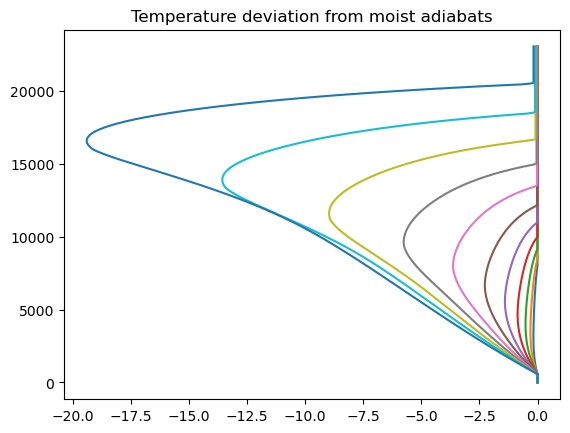

In [17]:
ssts = np.arange(265,315.1,5)
temps = ['265','270','275','280','285','290','295','300','305','310','315']

#BEST w ent = 4e-4
ztop_sst = np.arange(8000,18000.1,1000)
##################################
#USING:
ztop_sst = arr  #linear ramp BEST !
moistadi_100 = {}
for s,sst in enumerate(ssts):
    moistadi_100[temps[s]] = dry_moistad_wice_wSPM(T_0=sst-2,p_0=1000.,fstop=0.0008,zstop=23000.,dz=50.,rh_factor=1,zstop_dry=600,
                                    ztop_conv=ztop_sst[s], zb=600, ent=4.e-4, entexp=1.0)
plt.title('Temperature deviation from moist adiabats')

-------------spectral plume model (SPM) calculations finished----------------------------------------

From here on some diagnostic plots for the supplement

### Figure S3: temperature profiles simulated by SAM (solid) and predicted (dashed)

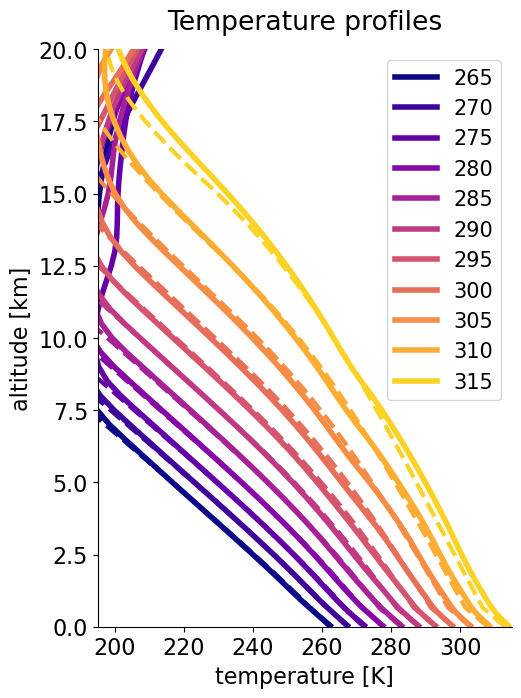

In [18]:
path2d ='../../data/SAM/'
varname = ['z','TABS','RADQR','RADQRLW','RADQRSW','SWNTOA','LWNTOA','LWNTOAC','SWNTOAC','LWNT','LWNS','LWDS','RADLWUP','RADLWDN',
           'RADSWUP','RADSWDN','CLD','RHO','RADQRCLW','RADQRCSW','RADQRC','QCI','QIA']
pvars = ['CRH']

fig = plt.figure()
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(12,7.5,forward=True)
pvars = ['CRH']
col = ['k','blue','deepskyblue','plum','g','limegreen','y','peru','orange','tomato','crimson']

ssts = np.arange(265,315.1,5)
cols = plt.cm.plasma(np.linspace(0, 1, len(ssts)+1))

# Format the ssts array with 3 significant digits
ssts = [f'{value:.3g}' for value in ssts]

tempmax = np.zeros(len(ssts))
tempmaxcld = np.zeros(len(ssts))
gs = fig.add_gridspec(1,20, height_ratios=[1], width_ratios=20*[1])

b=[]
# loop over the variables to plot
for v, pvar in enumerate(pvars):
    ax = fig.add_subplot(gs[0,0:9])

    # loop over the temperatures to plot
    for t, mtemp in enumerate(temps):
        # open the netCDF file and extract the data
        data_2d = ncopen(path2d+f'RCE{mtemp}_P3_96x96x74_1km_rcemip.nc', varname, ind=slice(None))
        alt = data_2d['z'].squeeze()
        temp = np.nanmean(data_2d['TABS'][-600:], axis=0)
        rho = np.nanmean(data_2d['RHO'][-600:], axis=0)
        iwc = np.nanmean(data_2d['QIA'][-600:], axis=0)*rho
        cld = np.nanmean(data_2d['CLD'][-600:], axis=0)
        
        qrad = np.nanmean(data_2d['RADQR'][-600:].squeeze() - data_2d['RADQRCLW'][-600:].squeeze() - data_2d['RADQRCSW'][-600:].squeeze(),axis=0)
        plotvar = qrad
        tempmax[t] = temp[np.nanargmax(qrad)]
        tempmaxcld[t] = temp[np.nanargmax(cld)]
        
        b.append(plt.plot(temp, alt/1e3, color=cols[t], linewidth=4, label=f'{varname} ({temp})')[0])
        plt.plot(moistadi_100[mtemp][2],moistadi_100['295'][0]/1e3,color=cols[t],label='MADB+SPM',linewidth=3,linestyle='--')

    # set the plot limits and labels
    plt.ylim(0,20)
    plt.xlim(195,315)

    plt.axvline(0, color='k', linewidth=0.75)
    plt.title('Temperature profiles',y=1.02)
    plt.xlabel('temperature [K]')
    if v==0:
        plt.ylabel('altitude [km]')#, size=24)
    if v==0:
        plt.legend(b,ssts,fontsize=15)
currentAxis = plt.gca()
currentAxis.spines['top'].set_visible(False)
currentAxis.spines['right'].set_visible(False)

#######################################################
#plt.savefig('/path-to-figure/FigS3_SAM_temp_profiles.pdf',dpi=200,bbox_inches='tight')

### Some diagnostic plots for peak CRH/CLD temp

In [19]:
# target vertical levels for the interpolation
zlev_int = np.arange(0, 24.001, 0.05) #50 m 

temp_interpq = np.zeros((11,len(zlev_int)))
temp_interpq1 = {}
rho_interpq = {}
tempmax_interpq = np.zeros((11))
tempmaxcld_interpq = np.zeros((11))
qradmax_interpq = np.zeros((11))
rhomax_interpq = np.zeros((11))

# loop over the temperatures to plot
for t, mtemp in enumerate(temps):
    # open the netCDF file and extract the data
    data_2d = ncopen(path2d+f'RCE{mtemp}_P3_96x96x74_1km_rcemip.nc', varname, ind=slice(None))
    alt = data_2d['z'].squeeze()
    temp = np.nanmean(data_2d['TABS'][-600:], axis=0)
    rho = np.nanmean(data_2d['RHO'][-600:], axis=0)
    iwc = np.nanmean(data_2d['QIA'][-600:], axis=0)*rho
    cld = np.nanmean(data_2d['CLD'][-600:], axis=0)

    qrad = np.nanmean(data_2d['RADQR'][-600:].squeeze() - data_2d['RADQRCLW'][-600:].squeeze() - data_2d['RADQRCSW'][-600:].squeeze(),axis=0)
    qrad_interpq = vertinterpolate(qrad,alt/1e3,zlev_int,kind="cubic",method='scipy')
    cld_interpq = vertinterpolate(cld,alt/1e3,zlev_int,kind="cubic",method='scipy')
    temp_interpq = vertinterpolate(temp,alt/1e3,zlev_int,kind="cubic",method='scipy')
    temp_interpq1[mtemp] = temp_interpq
    
    rho_interpq[mtemp] = vertinterpolate(rho,alt/1e3,zlev_int,kind="cubic",method='scipy')
    rho1 = vertinterpolate(rho,alt/1e3,zlev_int,kind="cubic",method='scipy')
    tempmax_interpq[t] = temp_interpq[np.nanargmax(qrad_interpq)]
    print(t,np.nanargmax(qrad_interpq))
    tempmaxcld_interpq[t] = temp_interpq[np.nanargmax(cld_interpq)]
    
    #max qrad and rho interpolated!!!
    qradmax_interpq[t] = np.nanmax(qrad_interpq)
    rhomax_interpq[t] = rho1[np.nanargmax(qrad_interpq)]

0 84
1 100
2 115
3 129
4 143
5 158
6 168
7 195
8 216
9 244
10 297


See below a comparison for e.g. our reference, 295 K temperature at peak CRH

### Figure S3: temperature at peak cloud fraction and at peak CRH
if you have problems in displaying this figure, just execute the cell again

In [31]:
ssts = np.arange(265,315.1,5)
ssts = ssts.astype(float)
tempmaxcld_interpq = tempmaxcld_interpq.astype(float)

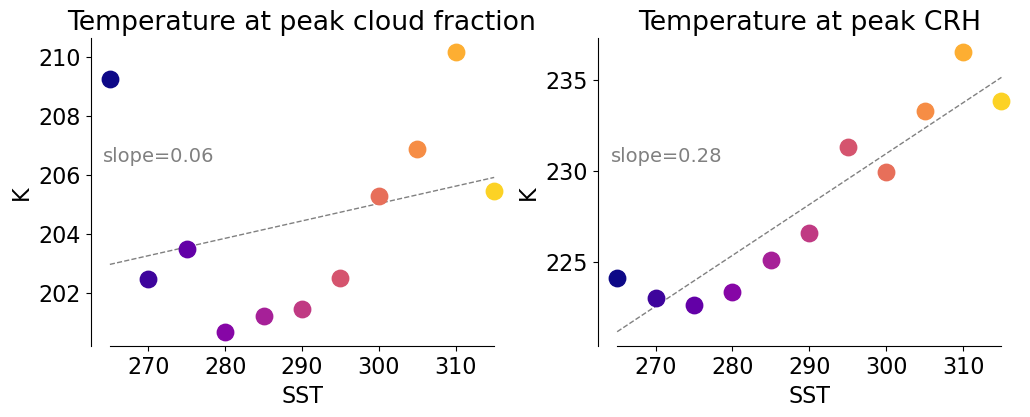

In [32]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12,4,forward=True)
slope=np.zeros(2)
for i in range(len(tempmax)):
    axs[0].scatter(ssts[i], tempmaxcld_interpq[i], color=cols[i], label=ssts[i],s=140,zorder=9)
    axs[1].scatter(ssts[i], tempmax_interpq[i], color=cols[i], label=ssts[i],s=140,zorder=9)
axs[0].set_title('Temperature at peak cloud fraction')
axs[1].set_title('Temperature at peak CRH')
for ax in axs.flat:
    ax.set(xlabel='SST', ylabel='K')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(265, 315)
    

# Linear regression using scipy.stats.linregress => only till SST=300K
slope[0], intercept, r_value, p_value, std_err = linregress(ssts[:], tempmaxcld_interpq)
regression_line1 = slope[0] * ssts + intercept
slope[1], intercept2, r_value2, p_value2, std_err2 = linregress(ssts[:], tempmax_interpq)
regression_line2 = slope[1] * ssts + intercept2
# Plotting the regression line
axs[0].plot(ssts, regression_line1, color='gray', linestyle='--', linewidth=1, label=f'Regression Line (R-squared = {r_value**2:.3f})')
axs[1].plot(ssts, regression_line2, color='gray', linestyle='--', linewidth=1, label=f'Regression Line (R-squared = {r_value**2:.3f})')
slope = slope.round(2)
for a,ax in enumerate(axs.flat):
    ax.text(0.03, 0.6, 'slope='+ str(slope[a]),transform=ax.transAxes,fontsize=14,color='gray')    
    
#plt.savefig('/save-path/Fig_S3_peakCLD_CRH_temp_interp_cubic.pdf',dpi=200,bbox_inches='tight')

## Calculate values needed for the prediction used in Fig. 2 (methods figure) and in Fig. 3
We are using:
1. predicted T_cloud peak based on the MADLR+SPM for reference SST=295 (moistadi_100[t][2] variable) + density of reference run too!
2. Assuming no change in temperature, find densities for same temperatures in all simulation
3. Compute the prediction

Use the predicted value of rho, based on the cubic interpolation of simulated rho values from SAM L74 (standard RCEMIP simulation/vertical grid)

We assume we know the T profile for the simulation at 295 K (our reference profile) and maximum temperature at peak CRH for simulation at 295 K

In [23]:
rho_isopredict = {}
for s,sst in enumerate(temps): #tempmax_interpq[6] = 231.3
    rho_isopredict[sst] = rho_interpq['295'][find_nearest(moistadi_100[sst][2],tempmax_interpq[6])] 

Search for the shift - here done manually, assuming isothermal shift!

In [24]:
find_nearest(moistadi_100['295'][2],tempmax_interpq[6]),find_nearest(moistadi_100['305'][2],
            tempmax_interpq[6]),sst,zlev_int[223],zlev_int[170],zlev_int[223]-zlev_int[170],223-170

(170, 223, '315', 11.15, 8.5, 2.6500000000000004, 53)

Sensitivity test: Assume we perfectly know the temperature at peak CRH (gray dotted line in the method figure)

In [25]:
find_nearest(moistadi_100['295'][2],tempmax_interpq[6]),find_nearest(moistadi_100['305'][2],
            tempmax_interpq[8]),sst,zlev_int[219],zlev_int[170],zlev_int[219]-zlev_int[170],219-170

(170, 219, '315', 10.950000000000001, 8.5, 2.450000000000001, 49)

### Figure 2: Methods plot on the example of SAM 295 K (taken as reference) and 305 K simulations

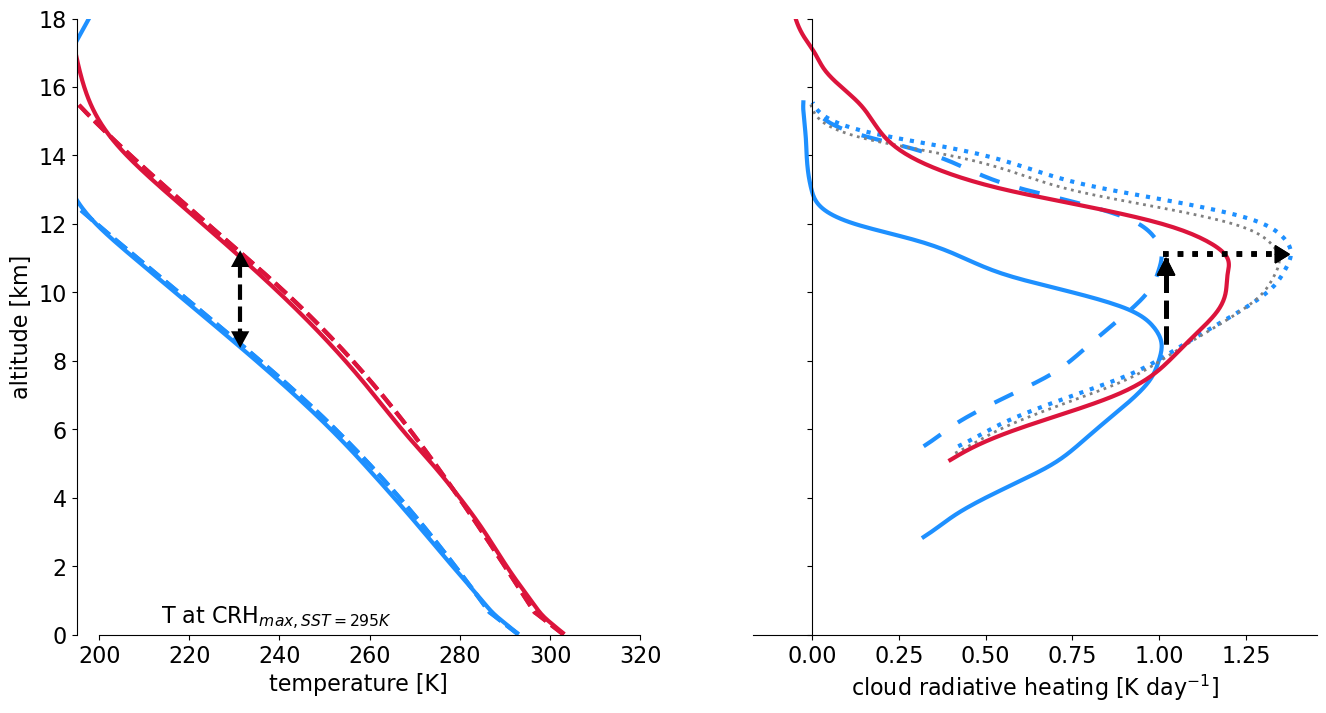

In [26]:
ncol = ['dodgerblue','crimson']

# target vertical levels for the interpolation
zlev_int = np.arange(0, 24.001, 0.05) #50 m 

fig = plt.figure()
fig.set_size_inches(16,8,forward=True)
gs = gridspec.GridSpec(1,2,height_ratios=[1],width_ratios=2*[1])
ssts = ['295','305']
#ratio plots: 6x4 per subplot!

y0 = [0,0,0,2,2,2,4,4,4,6,6,6,8,8,8,10,10,10,12,12,12]
x0 = [0,10,20]*6

altmax = np.zeros(len(ssts))
variables = ['temp','qrad']
for v,variable in enumerate(variables[:2]):
    ax = fig.add_subplot(gs[0,v])

    #plt.text(0.12,0.95,abc[v]+')',transform=ax.transAxes,horizontalalignment='left',
    #             verticalalignment='top',fontsize=24,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=1))
    
    for s,sst in enumerate(ssts):
            # 1. open the netCDF file and extract the data
            data_2d = ncopen(path2d+f'RCE{sst}_P3_96x96x74_1km_rcemip.nc', varname, ind=slice(None))
            alt = data_2d['z'].squeeze()
            temp = np.nanmean(data_2d['TABS'][-600:], axis=0)
            rho = np.nanmean(data_2d['RHO'][-600:], axis=0)
            iwc = np.nanmean(data_2d['QIA'][-600:], axis=0)*rho
            qrad = np.nanmean(data_2d['RADQR'][-600:].squeeze() - data_2d['RADQRCLW'][-600:].squeeze() - data_2d['RADQRCSW'][-600:].squeeze(),axis=0)
            # 2. interpolate to a finer, 50 m vertical grid using cubic interpolation
            qrad = vertinterpolate(qrad,alt/1e3,zlev_int,kind="cubic",method='scipy')
            temp = vertinterpolate(temp,alt/1e3,zlev_int,kind="cubic",method='scipy')
            rho = vertinterpolate(rho,alt/1e3,zlev_int,kind="cubic",method='scipy')
            iwc = vertinterpolate(iwc,alt/1e3,zlev_int,kind="cubic",method='scipy')

            if v ==0:
                temp295 = temp
                plt.plot(temp, zlev_int,color=ncol[s],linewidth=3,linestyle='-')
                plt.plot(moistadi_100['295'][2],moistadi_100['295'][0]/1e3,'dodgerblue',label='RH=90 hvtemp',linewidth=3,linestyle='--')
                plt.plot(moistadi_100['305'][2],moistadi_100['295'][0]/1e3,'crimson',label='RH=90 hvtemp',linewidth=3,linestyle='--')
                plt.xlim(195,320)
                plt.xlabel('temperature [K]')
                plt.ylabel('altitude [km]')

                plt.text(0.15,0.05,'T at CRH$_{max,SST=295K}$',transform=ax.transAxes,horizontalalignment='left',
                verticalalignment='top',fontsize=16,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=1))

                ax.spines['bottom'].set_bounds(200,320)

                if s==0:
                    #arrow predicted shift
                    plt.arrow(x=-0+temp[np.nanargmax(qrad)], y=8.7, dx=0, dy=-0.2,color='k',linewidth=3,
                              head_length = 0.3, head_width = 2.5, length_includes_head = True,zorder=111)
                    plt.vlines(x=-0+temp[np.nanargmax(qrad)],ymin=8.5,ymax=10.9,linestyle='--', color = 'k',linewidth=3)
                    plt.arrow(x=-0+temp[np.nanargmax(qrad)], y=10.9, dx=0, dy=0.2,color='k',linewidth=3,
                              head_length = 0.3, head_width = 2.5, length_includes_head = True,zorder=111)  
                
            else: #CRH Plot
                qrad[temp>273.15]=np.nan
                qrad[iwc<1e-8]=np.nan
                altmax[s] = zlev_int[np.nanargmax(qrad)]

                plt.plot(qrad, zlev_int,color=ncol[s],linewidth=3,linestyle='-') #color=col[s],linewidth=1,linestyle='--')            
                plt.xlabel('cloud radiative heating [K day$^{-1}$]')
                if s==0: #295 K
                    #1. isothermal CRH shift
                    #from altmax we know it's 2.65 km =53 indices here!! 
                    gsam_shift=shift_elements(qrad,53,0) 
                    gsam_shift[temp>273.15]=np.nan
                    gsam_shift[iwc<1e-8]=np.nan
                    plt.plot(gsam_shift,zlev_int,'dodgerblue',linestyle=(0, (5, 5)),linewidth=3)

                    #2. density factor 
                    gsam_dens_shift=shift_elements(rho,53,0)
                    gsam_densfac=gsam_dens_shift/rho
                    gsam_densfac[temp>273.15]=np.nan
                    gsam_shift[iwc<1e-8]=np.nan
                    plt.plot(gsam_shift*gsam_densfac,zlev_int,'dodgerblue',linestyle=':',linewidth=3)

                    #2. assuming the inferred change in temp at peak CRH (0.28)
                    #from altmax we know it's 2.35 km =47 indices here!
                    gsam_shift=shift_elements(qrad,49,0) 
                    gsam_shift[temp>273.15]=np.nan
                    gsam_shift[iwc<1e-8]=np.nan

                    #2. density factor 
                    gsam_dens_shift=shift_elements(rho,49,0)
                    gsam_densfac=gsam_dens_shift/rho
                    gsam_densfac[temp>273.15]=np.nan
                    gsam_shift[iwc<1e-8]=np.nan
                    plt.plot(gsam_shift*gsam_densfac,zlev_int,'gray',linestyle=':',linewidth=2)
                    
                ax.spines['left'].set_position(('data',0))
                ax.tick_params(axis='y', which='major', pad=35)
                ax.get_yaxis().set_ticklabels([])
                
                #arrow ideal shift
                plt.arrow(x=1.02, y=10.8, dx=0, dy=0.2,color='k',
                          head_length = 0.5, head_width = 0.05, length_includes_head = True,zorder=111)
                plt.vlines(x=1.02,ymin=8.5,ymax=11.,linestyle='--', color = 'k',linewidth=3.5)
                #arrow intensity 
                plt.arrow(x=1.36, y=11.11, dx=0.015, dy=0.0,color='k',
                          head_length = 0.04, head_width = 0.5, length_includes_head = True,zorder=111)
                plt.hlines(y=11.11,xmin=1.01,xmax=1.36,linestyle=':', color = 'k',linewidth=4)

            plt.ylim(0,18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#plt.savefig('/path-to-figure/Fig2_method_SAM295to305.pdf',dpi=200,bbox_inches='tight')

### Figure 3: model-simulated cloud fraction, CRH. Panel c) shows the CRH prediction.

Text(0.5, 1.02, 'Peak cloud radiative heating')

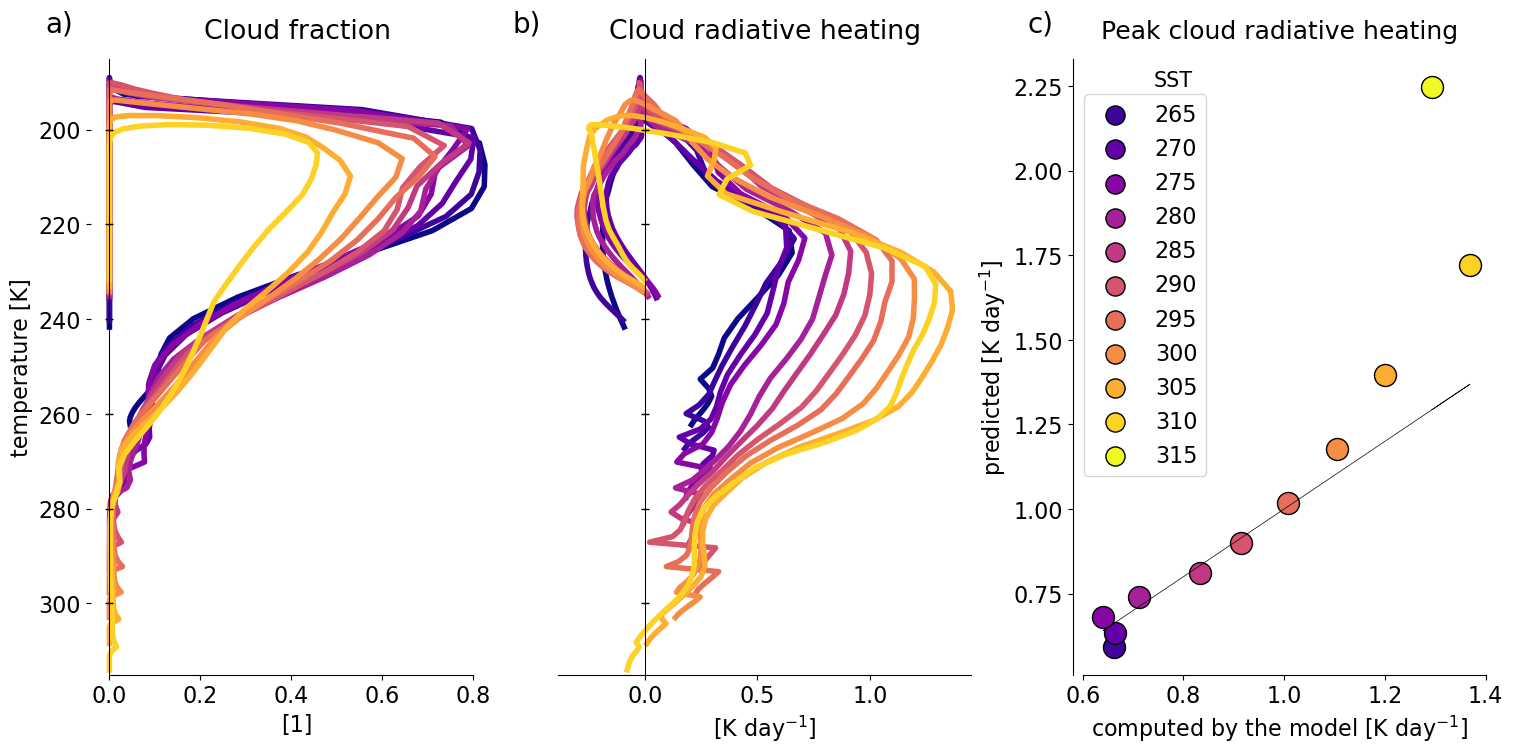

In [27]:
fig = plt.figure()
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(18,8,forward=True)
pvars = ['CLD','CRH']
col = ['k','blue','deepskyblue','plum','g','limegreen','y','peru','orange','tomato','crimson']

ssts = np.arange(265,315.1,5)
cols = plt.cm.plasma(np.linspace(0, 1, len(ssts)+1))

# Format the ssts array with 3 significant digits
ssts = [f'{value:.3g}' for value in ssts]

gs = fig.add_gridspec(1,30, height_ratios=[1], width_ratios=30*[1])
########################################################################################
# loop over the variables to plot
for v, pvar in enumerate(pvars):
    ax = fig.add_subplot(gs[0,v*10:v*10+9])
    currentAxis = plt.gca()
    
    # loop over the temperatures to plot
    for t, temp in enumerate(temps):
        # open the netCDF file and extract the data
        data_2d = ncopen(path2d+f'RCE{temp}_P3_96x96x74_1km_rcemip.nc', varname, ind=slice(None))
        alt = data_2d['z'].squeeze()
        temp = np.nanmean(data_2d['TABS'][-600:], axis=0)
        rho = np.nanmean(data_2d['RHO'][-600:], axis=0)
        iwc = np.nanmean(data_2d['QIA'][-600:], axis=0)*rho
        if v==1:
            qrad = np.nanmean(data_2d['RADQR'][-600:].squeeze() - data_2d['RADQRCLW'][-600:].squeeze() - data_2d['RADQRCSW'][-600:].squeeze(),axis=0)
            plotvar = qrad
        else:
            plotvar = np.nanmean(data_2d[pvar][-600:], axis=0)
        plt.plot(plotvar, temp, color=cols[t], linewidth=4, label=f'{varname} ({temp})')

    # set the plot limits and labels
    plt.ylim(315, 185)

    vertticks = [300,280,260,240,220,200]
    plt.axvline(0, color='k', linewidth=0.75)

    if v==1:
        plt.title('Cloud radiative heating',y=1.02)
        plt.xlabel('[K day$^{-1}$]')
        
        plt.yticks([])
        plt.plot([0,0,0,0,0,0],[vertticks[i] for i in range(0,6)], marker="_", label="points",color='k',linewidth=0.75)
        
    if v==0:
        currentAxis.spines['bottom'].set_bounds(0.,0.8)
        currentAxis.spines['left'].set_visible(False)

        plt.title('Cloud fraction',y=1.02)
        plt.xlabel('[1]')
        plt.ylabel('temperature [K]')
        
        plt.plot([0,0,0,0,0,0],[vertticks[i] for i in range(0,6)], marker="_", label="points",color='k',linewidth=0.75)

        plt.text(-0.11,1.08,'a)',transform=ax.transAxes,horizontalalignment='left',
                 verticalalignment='top',fontsize=20,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=1))
        

    
    currentAxis.spines['left'].set_visible(False)
    currentAxis.spines['top'].set_visible(False)
    currentAxis.spines['right'].set_visible(False)

plt.text(-0.11,1.08,'b)',transform=ax.transAxes,horizontalalignment='left',
                 verticalalignment='top',fontsize=20,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=1))
############################################################################################################################
#PLOT 2

#dictionary to array transformation
rho_isopredict0 = np.array(list(rho_isopredict.values()))
rho_isopredict1=rho_isopredict0.reshape((11,1))
dfdz = qradmax_interpq*rhomax_interpq*1004
predict = dfdz[6]*1/rho_isopredict0/1004 #usign predicted rho values
predict2 = dfdz[6]*1/rhomax_interpq/1004 #knowing perfect density value

dfdz_p= dfdz.reshape((11,1))
relanom =np.copy(dfdz)
for i in range(len(dfdz)):
    relanom[i] = 100*(dfdz[i] -dfdz_p[6])/dfdz_p[6]
relanom=relanom.reshape((11,1))

rhoanom=np.copy(dfdz)
#for i in range(len(dfdz)):
for i,sst in enumerate(temps):    
    rhoanom[i] = 100*(rho_isopredict[sst]-rhomax_interpq[i])/rhomax_interpq[i]
rhoanom=rhoanom.reshape((11,1))


cols = plt.cm.plasma(np.linspace(0, 1, len(ssts)+1))
b=[]
ax = fig.add_subplot(gs[0,21:30])
for i in range(len(qradmax_interpq)):
    plt.scatter(qradmax_interpq[i], predict[i], color='k', label=ssts[i],s=250)
    b.append(plt.scatter(qradmax_interpq[i], predict[i], color=cols[i+1], label=ssts[i],s=190))
plt.ylabel('predicted [K day$^{-1}$]')
plt.xlabel('computed by the model [K day$^{-1}$]')
plt.plot(qradmax_interpq,qradmax_interpq,color='k',linewidth=0.5)
plt.xlim(0.58,1.4)
legend=plt.legend(b,ssts,fontsize=16,bbox_to_anchor=(0.35, 0.96))
for lh in legend.legendHandles:
        lh.set_edgecolor('black')

plt.text(0.74,2.25,'SST',fontsize=15)
#add a table with the values of dF/dz term:---------------------------
clevs = np.arange(-58,59,4)
tabnorm = colors.BoundaryNorm(clevs, ncolors=256, clip=False)
tcols = plt.cm.RdBu_r(tabnorm(relanom))

tcols2 = plt.cm.RdBu(tabnorm(rhoanom)) #density too small => value too large and vice versa!

currentAxis = plt.gca()
currentAxis.spines['top'].set_visible(False)
currentAxis.spines['right'].set_visible(False)
currentAxis.spines['bottom'].set_bounds(0.6,1.4)

plt.text(-0.11,1.08,'c)',transform=ax.transAxes,horizontalalignment='left',
             verticalalignment='top',fontsize=20,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=1))

########################---------------end-------------------------------
plt.title('Peak cloud radiative heating',fontsize=18,y=1.02)
#plt.savefig('/save-to-files/Fig3_SAM_CLD_CRH_rho295K_prediction.pdf',dpi=200,bbox_inches='tight')

Do some statistics: calculate correl coeff and RMSE

In [28]:
from sklearn.metrics import mean_squared_error

# calculate the correlation coefficient (r)
r = np.corrcoef(qradmax_interpq, predict)[0, 1]
print(f'Correlation coefficient (r): {r}')

# calculate the root mean square error (RMSE)
rmse = np.sqrt(mean_squared_error(qradmax_interpq, predict))
print(f'Root Mean Square Error (RMSE): {rmse}')

Correlation coefficient (r): 0.9134937868193864
Root Mean Square Error (RMSE): 0.31475808853059034


In [29]:
# calculate the correlation coefficient (r)
r = np.corrcoef(qradmax_interpq[1:-1], predict[1:-1])[0, 1]
print(f'Correlation coefficient (r): {r}')

# calculate the root mean square error (RMSE)
rmse = np.sqrt(mean_squared_error(qradmax_interpq[1:-1], predict[1:-1]))
print(f'Root Mean Square Error (RMSE): {rmse}')

Correlation coefficient (r): 0.9797640436309253
Root Mean Square Error (RMSE): 0.1381532448839551
